## Performance Improvements
----

As stated before, there is ample opportunity for improving the performance of the model so that larger datasets can be used.

sklearn provides multiple methods for obtaining the token vectors of documents. `CountVectorizer` is a simple method for getting this data but has several drawbacks:
  - The larger the dataset, the larger the vocabulary that needs to be stored
    - Prohibitively large datasets will have vocabularies that will not fit in memory
  - It cannot be easily parallelized into sub tasks
    - The vectorizer has an internal state that would have to be synchronized

`HashingVectorizer` by default opens a hashmap of $2^{20}$ possible vocabulary entries that are hashed into their correct entries. This opens the possibility of collisions, but that is a rare event. This vectorizer also has the benefit of being stateless, meaning it is much more easily parallelized for large datasets. However, there are down-sides to using this method:
  - There is obviously no way to invert the process and obtain the original documents that were fed in.
  - Inverse Document Frequency (IDF) cannot be integrated because there is no state to the vectorizer.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer, HashingVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_msgpack("./combined.msg")
df['fakeness'] = 0
df.loc[df['type'] < 2, 'fakeness'] = 1
smaller = df.groupby('fakeness').head(15000)
df.head()

,type,content,title,fakeness
0,0,\n\n\n\n\n\n\n\nRev Dr. Childress is available...,BlackGenocide.org,1
1,0,\n\nSpeaking Engagement Request\n\n\n\nContact...,Request Speaking Engagement,1
2,0,"""…I have set before you life and death, blessi...",BlackGenocide.org,1
3,0,Why We Oppose Planned Parent Hood ( The follow...,Why We Oppose Planned Parenthood,1
4,1,Headline: Bitcoin & Blockchain Searches Exceed...,Surprise: Socialist Hotbed Of Venezuela Has Lo...,1


In [3]:
text_clf = Pipeline([('vect', HashingVectorizer(n_features=2**18,
                                                alternate_sign=False,
                                                stop_words=ENGLISH_STOP_WORDS,
                                                ngram_range=(1,2))),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])

In [4]:
fitted = text_clf.fit(smaller.content.values, smaller.fakeness.values)

In [5]:
predicted = text_clf.predict(smaller.content.values)

In [6]:
print("Accuracy: " + str(np.mean(predicted == smaller.fakeness.values) * 100) + "%")

Accuracy: 95.45666666666666%


In [7]:
print(metrics.classification_report(smaller.fakeness, predicted, target_names=['real', 'fake']))

             precision    recall  f1-score   support

       real       0.95      0.96      0.95     15000
       fake       0.96      0.95      0.95     15000

avg / total       0.95      0.95      0.95     30000



## Optimization of Parameters
----

As stated before, this is an un-optimized classifier. scikit-learn provides a method for optimizing parameters for estimators in the form of [GridSearch](http://scikit-learn.org/stable/modules/grid_search.html). `estimator.get_params()` will provide all parameters that can be modified to attempt to obtain an optimal configuration.

In [8]:
text_clf.get_params()

{'memory': None,
 'steps': [('vect',
   HashingVectorizer(alternate_sign=False, analyzer='word', binary=False,
            decode_error='strict', dtype=<class 'numpy.float64'>,
            encoding='utf-8', input='content', lowercase=True,
            n_features=262144, ngram_range=(1, 2), non_negative=False,
            norm='l2', preprocessor=None,
            stop_words=frozenset({'none', 'mostly', 'as', 'his', 'hence', 'rather', 'twelve', 'when', 'hereby', 'get', 'who', 'out', 'us', 'only', 'becoming', 'hereupon', 'ltd', 'may', 'fifteen', 'both', 'might', 'less', 'myself', 'other', 'side', 'that', 'be', 'nothing', 'until', 'whence', 'am', 'below', 'firs...', 'over', 'by', 'everything', 'anywhere', 'call', 'our', 'had', 'several', 'hereafter', 'because'}),
            strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
            tokenizer=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf', MultinomialNB(alpha=1.0, cl

In [9]:
parameters = {
    'clf__alpha': np.linspace(0, 1, num=5)
}
print(parameters)
grid_search = GridSearchCV(text_clf, parameters)
grid_search.fit(smaller.content.values, smaller.fakeness.values)
print(grid_search)
print(grid_search.best_score_)

{'clf__alpha': array([0.  , 0.25, 0.5 , 0.75, 1.  ])}


/usr/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', HashingVectorizer(alternate_sign=False, analyzer='word', binary=False,
         decode_error='strict', dtype=<class 'numpy.float64'>,
         encoding='utf-8', input='content', lowercase=True,
         n_features=262144, ngram_range=(1, 2), non_negative=False,
         norm='l2', pr...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__alpha': array([0.  , 0.25, 0.5 , 0.75, 1.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
0.8271666666666667


In [10]:
print(grid_search.cv_results_)

{'mean_fit_time': array([17.24343228, 17.31409645, 18.12094943, 18.18152714, 17.59313536]), 'std_fit_time': array([0.27272906, 0.38513691, 0.25714857, 1.24343991, 0.04863733]), 'mean_score_time': array([8.67165923, 8.62054968, 9.38867434, 8.98600721, 8.74380779]), 'std_score_time': array([0.38736327, 0.46622605, 0.95515514, 0.27681799, 0.57780081]), 'param_clf__alpha': masked_array(data=[0.0, 0.25, 0.5, 0.75, 1.0],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'clf__alpha': 0.0}, {'clf__alpha': 0.25}, {'clf__alpha': 0.5}, {'clf__alpha': 0.75}, {'clf__alpha': 1.0}], 'split0_test_score': array([0.7871, 0.7878, 0.7858, 0.785 , 0.7864]), 'split1_test_score': array([0.8208, 0.8373, 0.8368, 0.8367, 0.836 ]), 'split2_test_score': array([0.7974, 0.8564, 0.8526, 0.8485, 0.8412]), 'mean_test_score': array([0.80176667, 0.82716667, 0.82506667, 0.8234    , 0.8212    ]), 'std_test_score': array([0.0141002 , 0.02890794, 0.02850513

In [23]:
# Obtained and modified from https://stackoverflow.com/a/43645640
def plot_grid_search(cv_results, grid_param, name_param):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']

    scores_sd = cv_results['std_test_score']

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    ax.plot(grid_param, scores_mean, '-o')

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.grid('on')

/usr/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


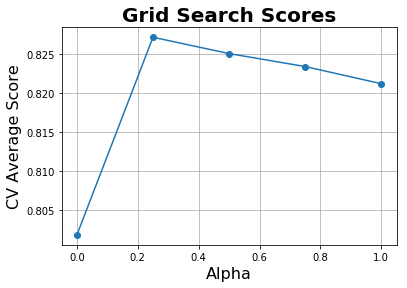

In [21]:
plot_grid_search(grid_search.cv_results_, np.linspace(0, 1, num=5), "Alpha")

/usr/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


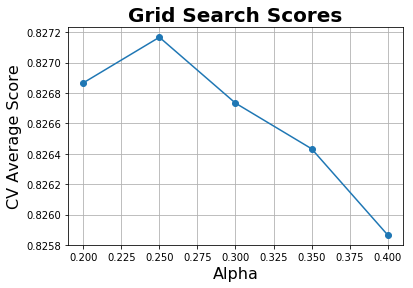

In [22]:
parameters = {
    'clf__alpha': np.linspace(.2, .4, num=5)
}
grid_search = GridSearchCV(text_clf, parameters)
grid_search.fit(smaller.content.values, smaller.fakeness.values)
plot_grid_search(grid_search.cv_results_, np.linspace(.2, .4, num=5), "Alpha")